In [1]:
import warnings
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score, f1_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN  # а также другие алгоритмы
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x = X[:, 0],y = X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

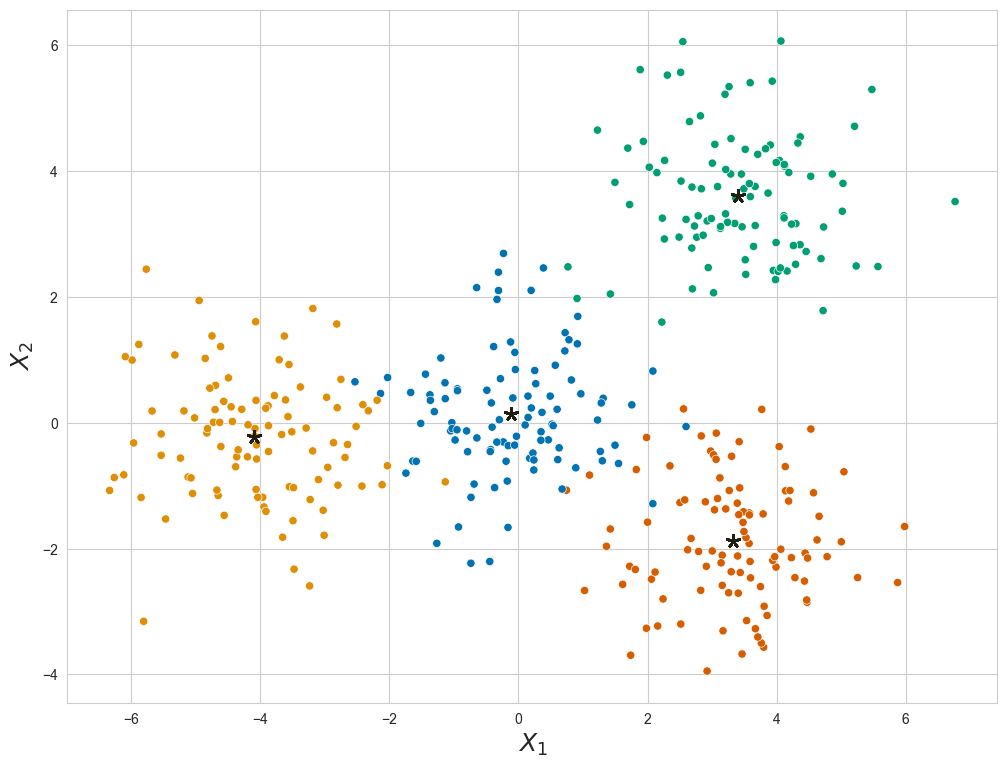

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        dist = np.linalg.norm(X - centroid, axis=1).reshape(X.shape[0], 1)
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

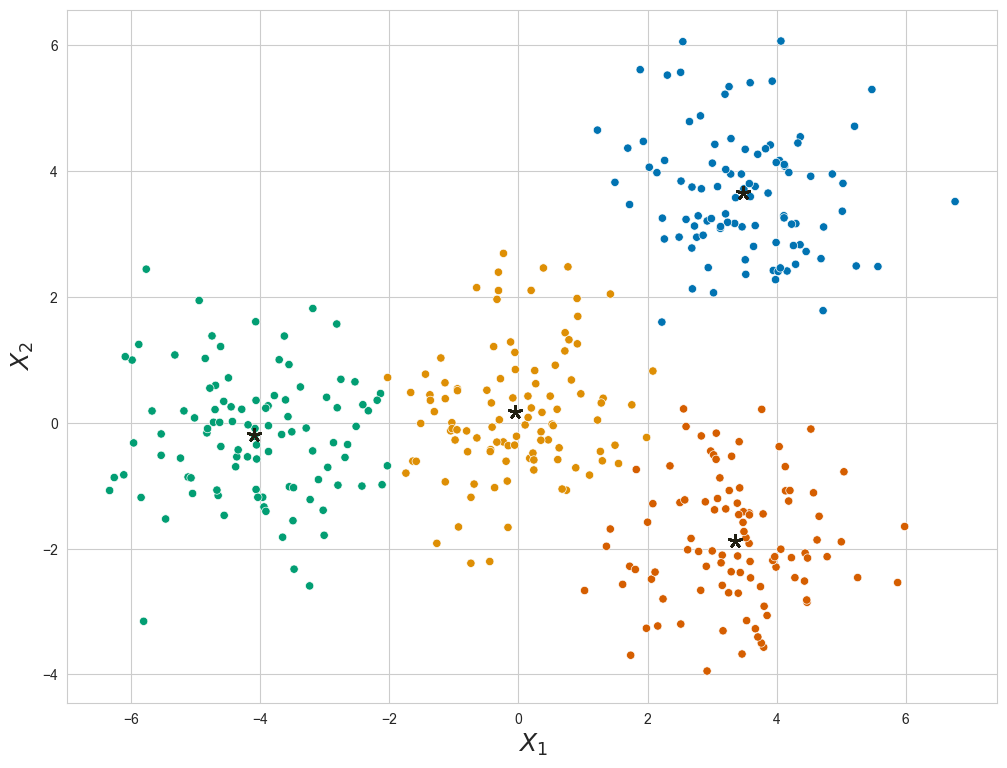

In [7]:
#Создадим модель с параметром init="random"
my_kmeans_random = MyKMeans(n_clusters=4, init="random", max_iter=20, visualize=True)
#Обучим модель
my_kmeans_random.fit(X)
#Предскажем кластеры
pred_random = my_kmeans_random.predict(X)

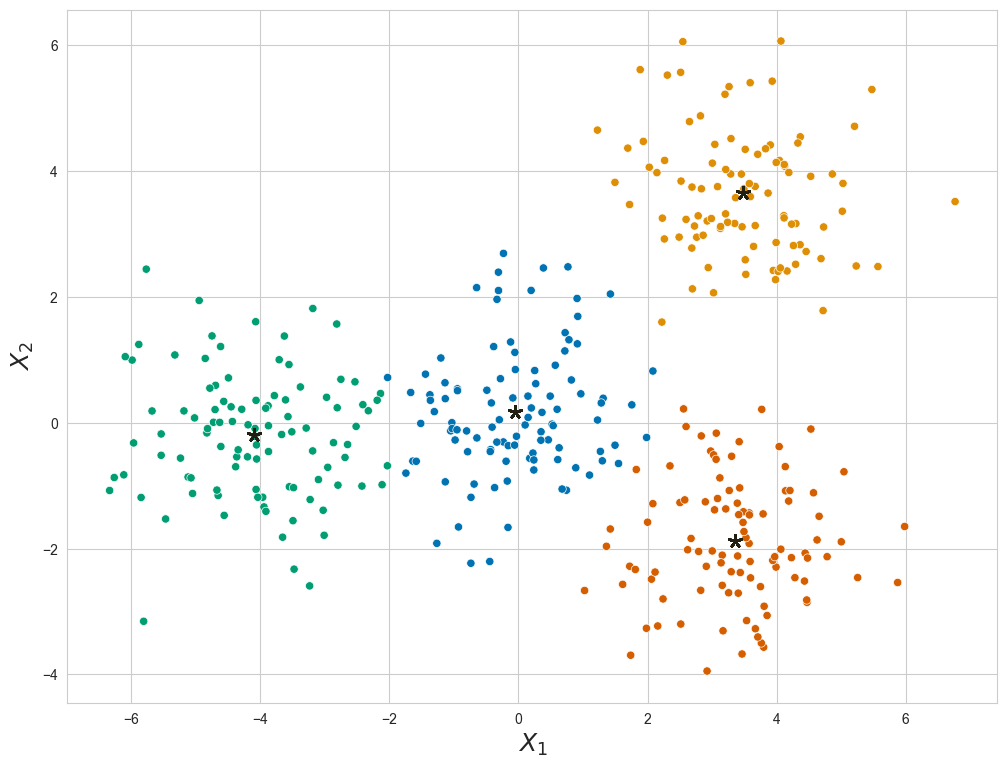

In [8]:
#Создадим модель с параметром init="sample"
my_kmeans_sample = MyKMeans(n_clusters=4, init="sample", max_iter=20, visualize=True)
#Обучим модель
my_kmeans_sample.fit(X)
#Предскажем кластеры
pred_sample = my_kmeans_sample.predict(X)

In [9]:
#Посмотрим на метрику качества (силуэт) для моделей с различными способами инициализации центроидов
print(f'Silhouette score(random): {silhouette_score(X, pred_random)}')
print(f'Silhouette score(sample): {silhouette_score(X, pred_sample)}')
#В данном случае способ инициализации центроидов не повлиял на качество (согласно метрике силуэт)

Silhouette score(random): 0.5643117184043004
Silhouette score(sample): 0.5643117184043004


### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [10]:
data = load_digits()
X, y = data.data, data.target

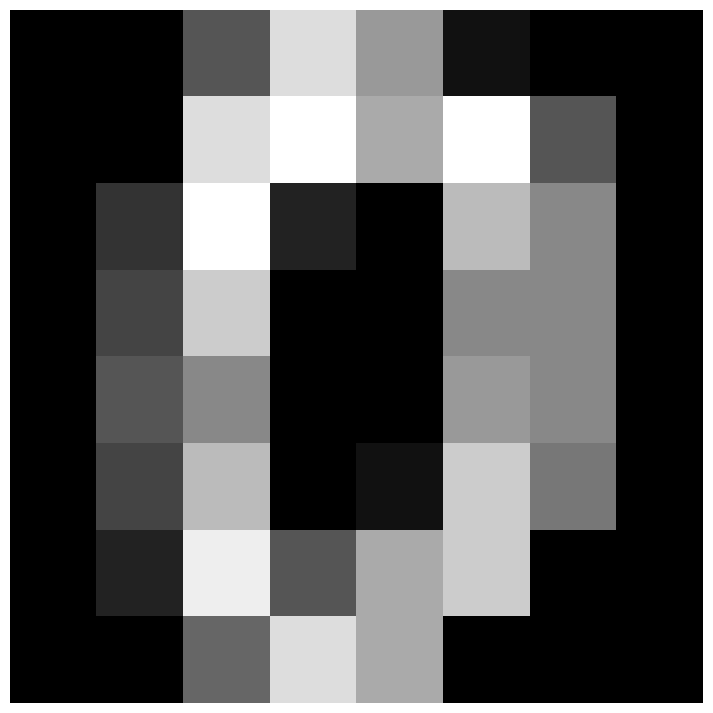

In [11]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [53]:
def algorithm_selection(X, y = None, n_clusters = None, distances = ('euclidean', 'manhattan', 'cosine','minkowski'), algorithms = ('average', 'single', 'complete')):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithms: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
        :params y = метки классов
        :param n_clusters: количество кластеров
    :return compare_dataframe: таблица с метриками кластеризации """
    
    if n_clusters is None:
        raise ValueError ("Enter the number of clusters")
    
    if y is not None:
        column_names = ['Distance', 'Algorithm', 'Silhouette', 'Homogeneity','Completeness', 'V-measure']
    else:
        column_names = ['Distance', 'Algorithm', 'Silhouette']
        
    compare_dataframe = pd.DataFrame(columns = column_names)
        
    for distance in distances:
        for algorithm in algorithms:
            clust_model = AgglomerativeClustering(n_clusters=n_clusters, metric = distance, linkage = algorithm)
            pred_clusters = clust_model.fit_predict(X)
        
        #считаем метрики
            silhouette_metric = silhouette_score(X, pred_clusters, metric = distance)
            if y is not None:
                homogeneity_metric = homogeneity_score(y, pred_clusters)
                completeness_metric = completeness_score(y, pred_clusters)
                v_measure_metric = v_measure_score(y, pred_clusters)
            
            if y is not None:
                row_dataframe = [distance, algorithm, homogeneity_metric, completeness_metric, v_measure_metric, silhouette_metric]
            else:
                row_dataframe = [distance, algorithm, silhouette_metric]
                
            compare_dataframe.loc[len(compare_dataframe)] = row_dataframe
        
    return compare_dataframe
        

In [54]:
algorithm_selection(X = X, y = y, n_clusters = 10)

Distance Algorithm  Silhouette  Homogeneity  Completeness  V-measure
0   euclidean   average    0.296248     0.918532      0.448004   0.472471
1   euclidean    single    0.002471     0.197414      0.004882   0.484108
2   euclidean  complete    0.428292     0.622369      0.507406   0.335454
3   manhattan   average    0.289060     0.894023      0.436870   0.495278
4   manhattan    single    0.002471     0.197414      0.004882   0.437938
5   manhattan  complete    0.461043     0.717993      0.561519   0.355605
6      cosine   average    0.947294     0.815265      0.876335   0.371119
7      cosine    single    0.000707     0.087342      0.001403  -0.429138
8      cosine  complete    0.881291     0.525848      0.658677   0.338097
9   minkowski   average    0.296248     0.918532      0.448004   0.472471
10  minkowski    single    0.002471     0.197414      0.004882   0.484108
11  minkowski  complete    0.428292     0.622369      0.507406   0.335454

Среди алгоритмов иерархической кластеризации лучше всего работают complete и average (в зависимости от выбора метрики расстояния). А среди метрик расстояния лучше всего показали себя: 'euclidean', 'manhattan' и 'minkowski'.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [14]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

In [15]:
fc_data.describe()
#В данных представлено 9 признаков и 10000 клеток

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [16]:
#Проверим тип данных 
fc_data.info()
#Все колонки - float

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [17]:
#Проверим данные на наличие пропусков
print(f"Количество пропусков:\n{fc_data.isna().sum() / len(fc_data)}")
print(f"Общее количество клеток: {len(fc_data)}")

Количество пропусков:
FSC-A     0.0
SSC-A     0.0
HLA-DR    0.0
CD3       0.0
CD45      0.0
CD14      0.0
CD56      0.0
CD19      0.0
CD11c     0.0
dtype: float64
Общее количество клеток: 10000


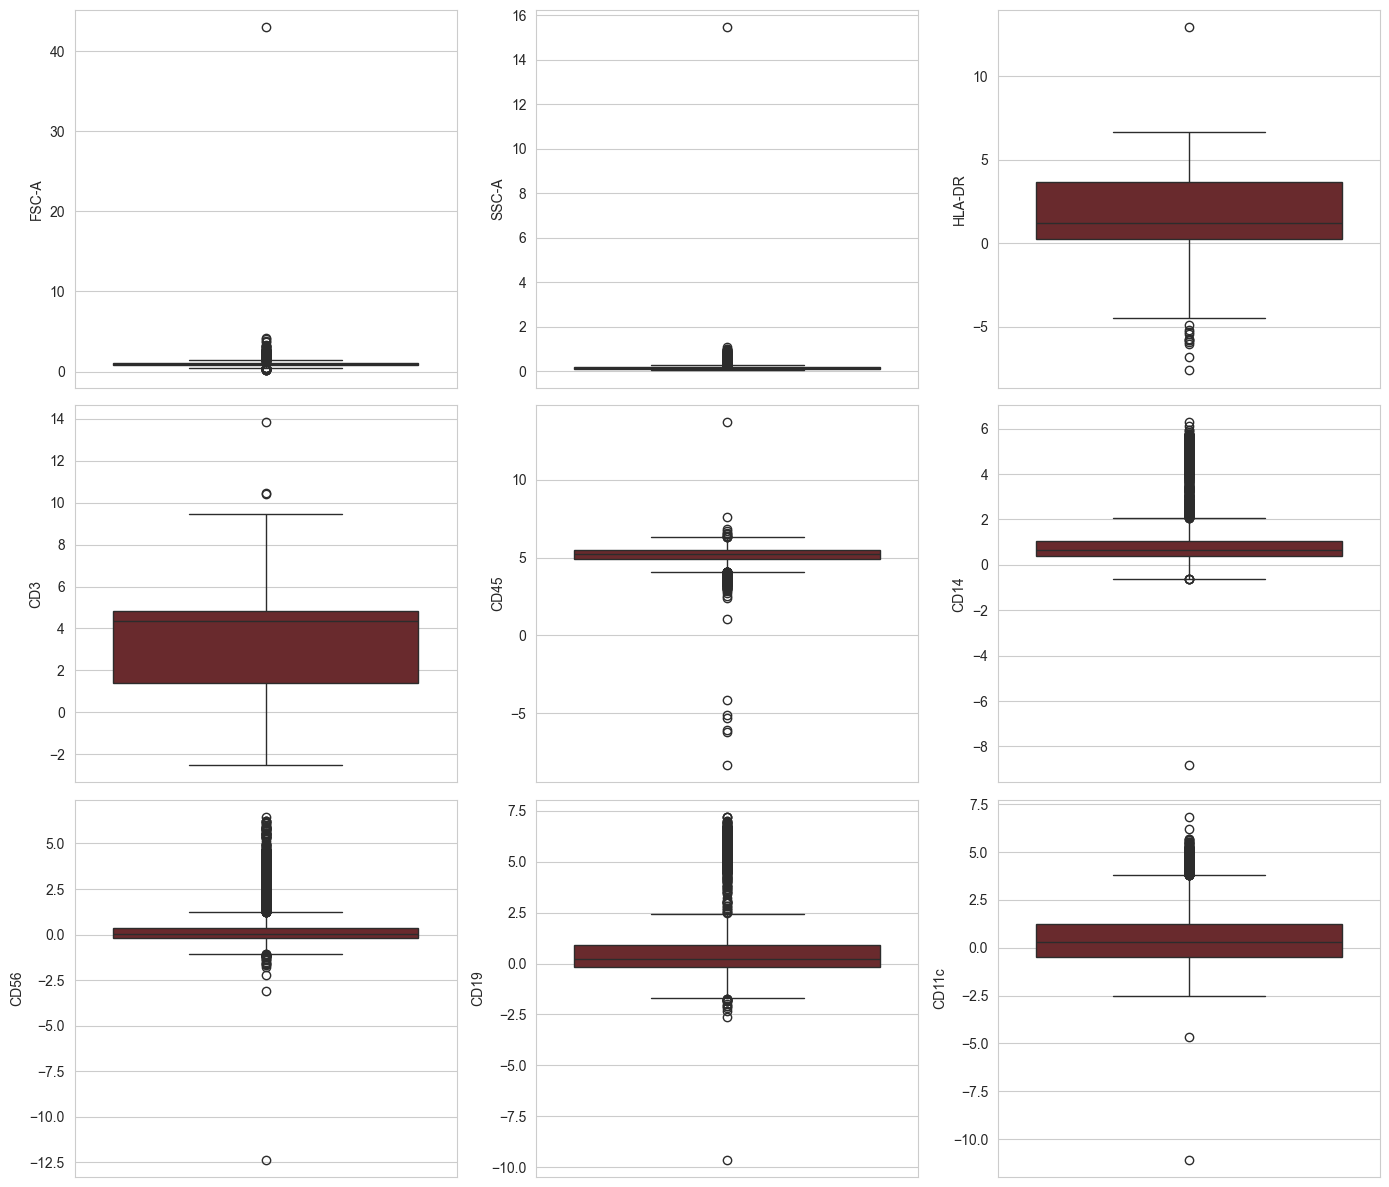

In [18]:
#Посмотрим на распределение данных
plt.rcParams["figure.figsize"] = 14, 12
i = 1
for col in fc_data.columns[:]:
  plt.subplot(3, 3, i)
  sns.boxplot(fc_data[col], color = '#732023')
  i += 1

plt.tight_layout();
#В данных есть выбросы 

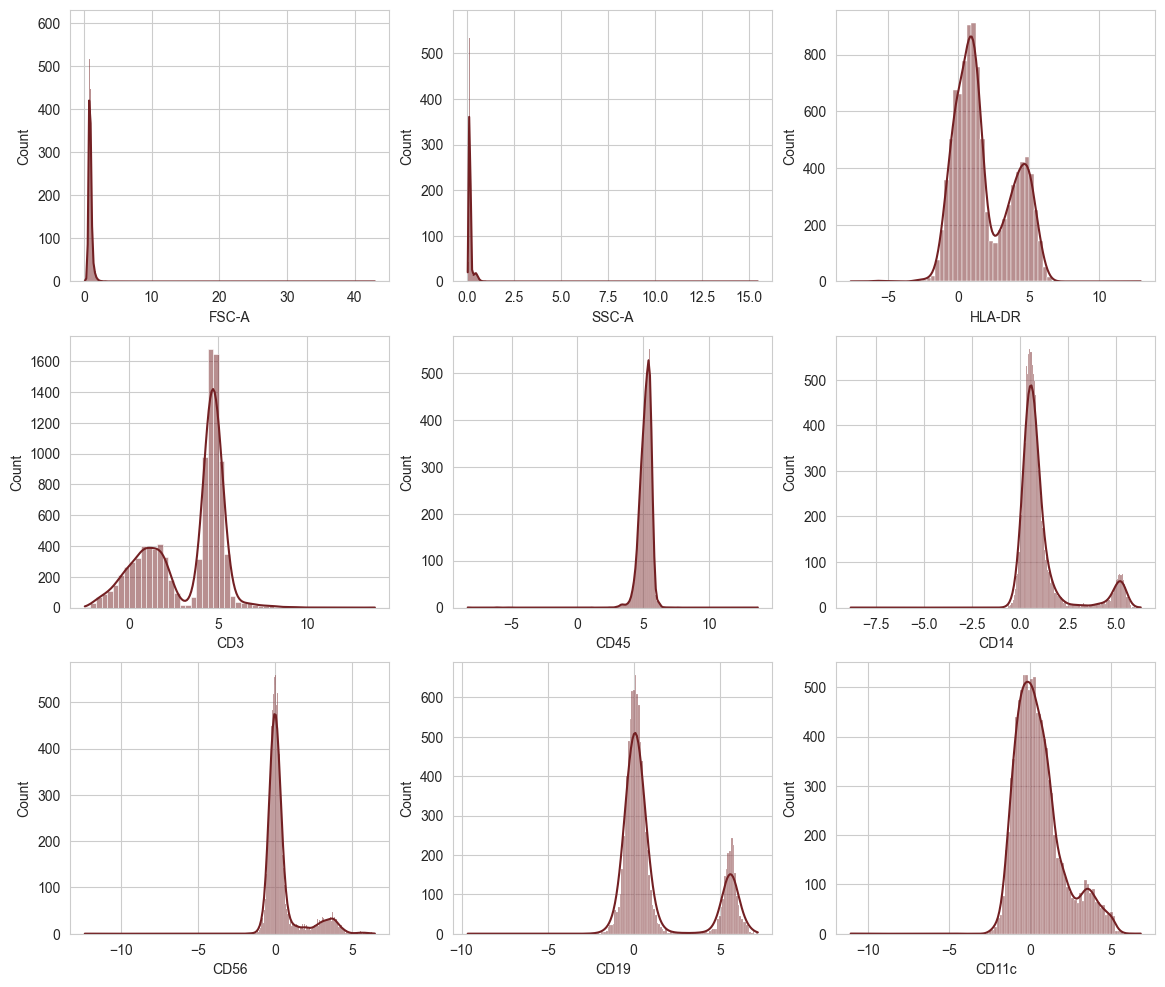

In [19]:
i = 1
for col in fc_data.columns[:]:
  plt.subplot(3, 3, i)
  sns.histplot(fc_data[col], color = '#732023',kde=True)
  i += 1

In [20]:
#Попробуем убрать выбросы и снова посмотреть на распределение
np.argmax(fc_data['FSC-A']) #5843
np.argmax(fc_data['SSC-A']) #5843
np.argmax(fc_data['HLA-DR']) #5843
np.argmax(fc_data['CD3']) #5843
np.argmin(fc_data['CD14']) #5843
np.argmin(fc_data['CD56']) #5843
np.argmin(fc_data['CD19']) #5843
np.argmin(fc_data['CD11c']) #5843
#удалим наблюдение с индексов 5843
fc_data_no_outliers = fc_data.drop(index = 5843)

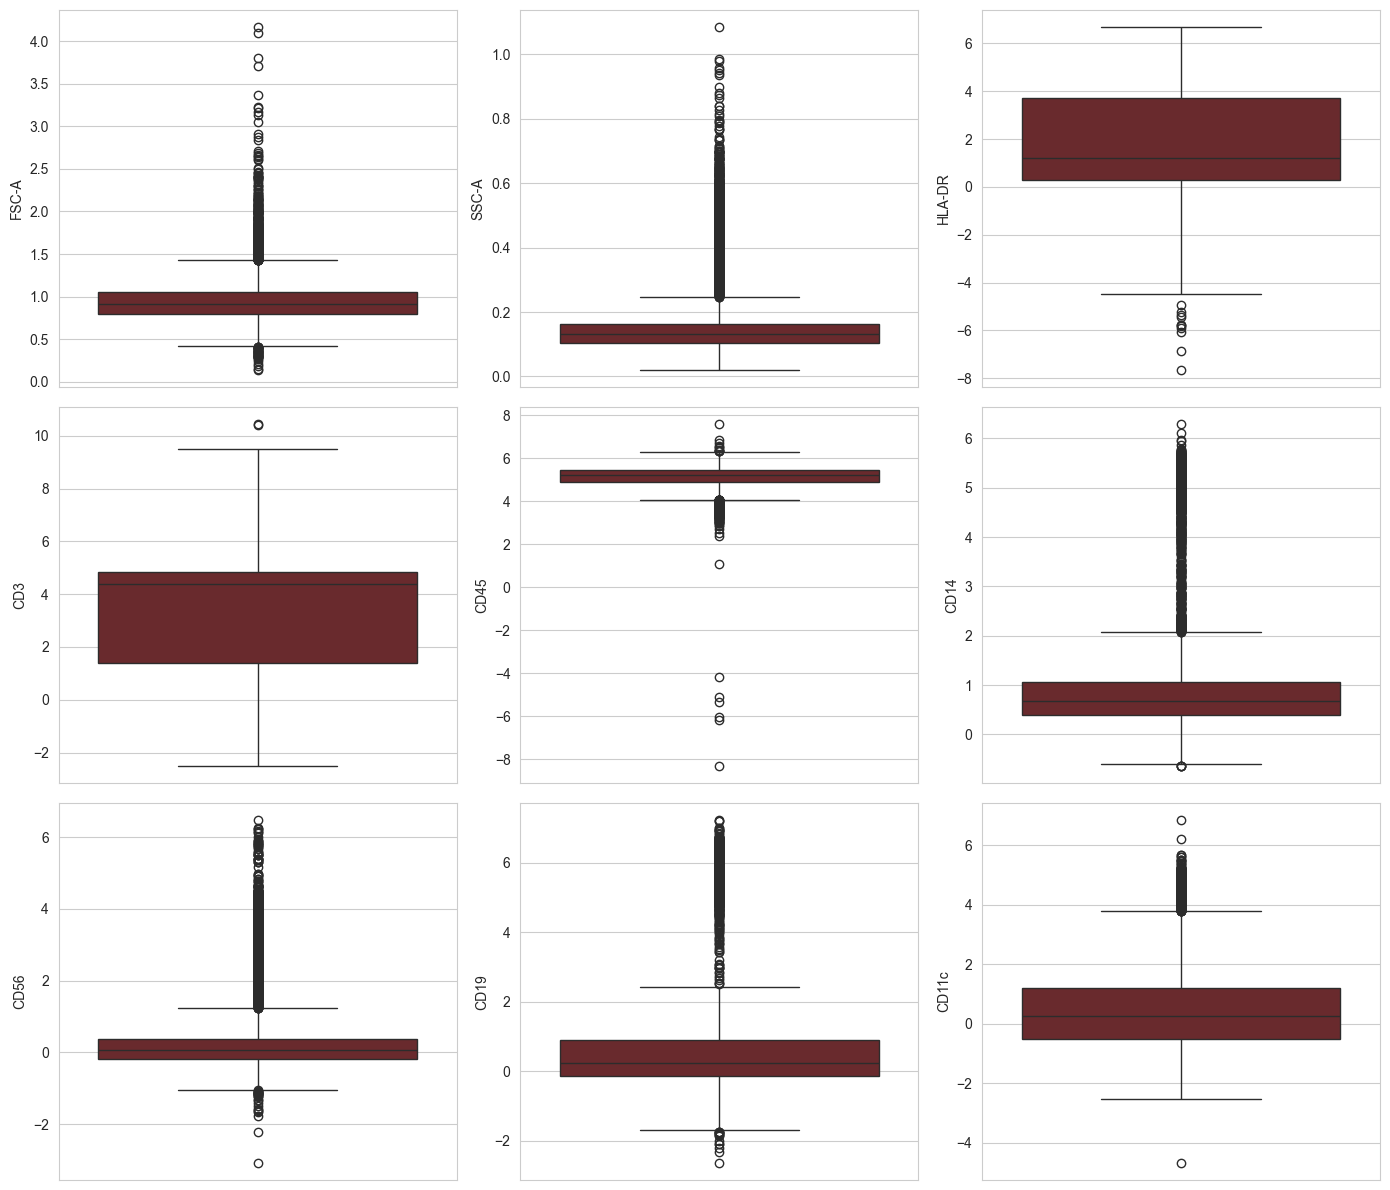

In [21]:
plt.rcParams["figure.figsize"] = 14, 12
i = 1
for col in fc_data_no_outliers.columns[:]:
  plt.subplot(3, 3, i)
  sns.boxplot(fc_data_no_outliers[col], color = '#732023')
  i += 1

plt.tight_layout();

In [22]:
#удалим выброс в группе CD11c
fc_data_no_outliers = fc_data_no_outliers.drop(index = np.argmin(fc_data_no_outliers['CD11c']))

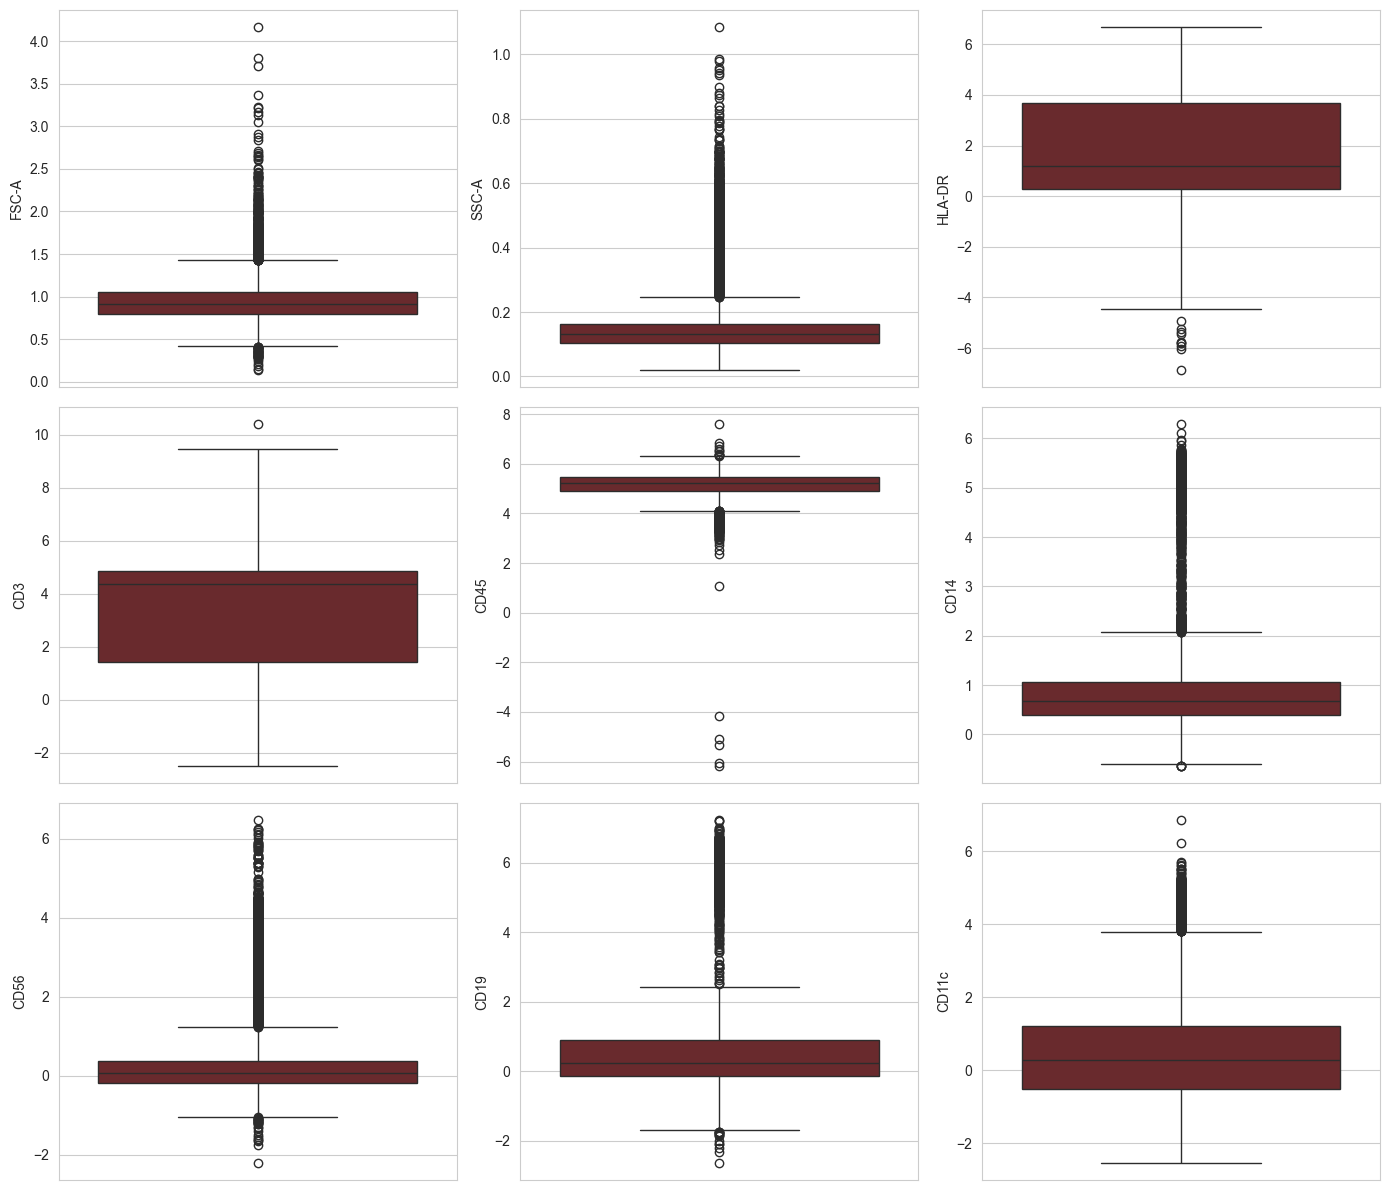

In [23]:
#Посмотрим на данные
plt.rcParams["figure.figsize"] = 14, 12
i = 1
for col in fc_data_no_outliers.columns[:]:
  plt.subplot(3, 3, i)
  sns.boxplot(fc_data_no_outliers[col], color = '#732023')
  i += 1

plt.tight_layout();

In [24]:
#Посмотрим на корреляцию
#Проверим нормальность распределения использованием теста Шапиро-Уилка
for col in fc_data_no_outliers.columns:
    print(f"{col} - {stats.shapiro(fc_data_no_outliers[col])}")
# p-value везде меньше 0.01, поэтому на уровне значимости 1% 
# гипотеза о нормальности отвергается для всех колонок

FSC-A - ShapiroResult(statistic=0.8482626794486643, pvalue=1.0044578062197113e-70)
SSC-A - ShapiroResult(statistic=0.6407099385136006, pvalue=1.030641677890134e-89)
HLA-DR - ShapiroResult(statistic=0.9313208881558235, pvalue=2.690506322647756e-55)
CD3 - ShapiroResult(statistic=0.875089065024822, pvalue=9.306768083928132e-67)
CD45 - ShapiroResult(statistic=0.7946956382703586, pvalue=4.018855135750249e-77)
CD14 - ShapiroResult(statistic=0.6507177185356232, pvalue=4.698754713707906e-89)
CD56 - ShapiroResult(statistic=0.6891564141949997, pvalue=2.3176594081774495e-86)
CD19 - ShapiroResult(statistic=0.7032612398300317, pvalue=2.6664819838158774e-85)
CD11c - ShapiroResult(statistic=0.9260565996621971, pvalue=1.1878599173871937e-56)


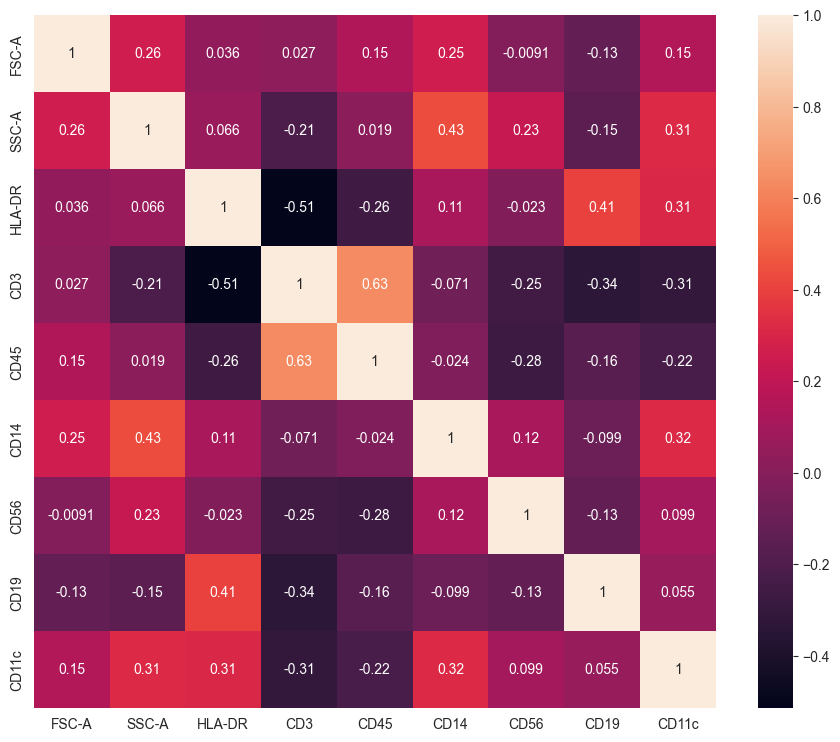

In [25]:
#Поскольку данные не имеют нормального распределения для подсчета корреляции будем использовать ранговый тест Спирмена.
plt.rcParams["figure.figsize"] = 11, 9
sns.heatmap(fc_data_no_outliers.corr(method="spearman"), annot=True);
#Можно заметить, что сильной корреляции между переменными не наблюдается

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [26]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

In [27]:
#Нормализуем данные
column_names = fc_data_no_outliers.columns.tolist()
scaler = StandardScaler()
scaler.fit(fc_data_no_outliers)
fc_data_no_outliers_norm = pd.DataFrame(data=scaler.transform(fc_data_no_outliers), columns=column_names)

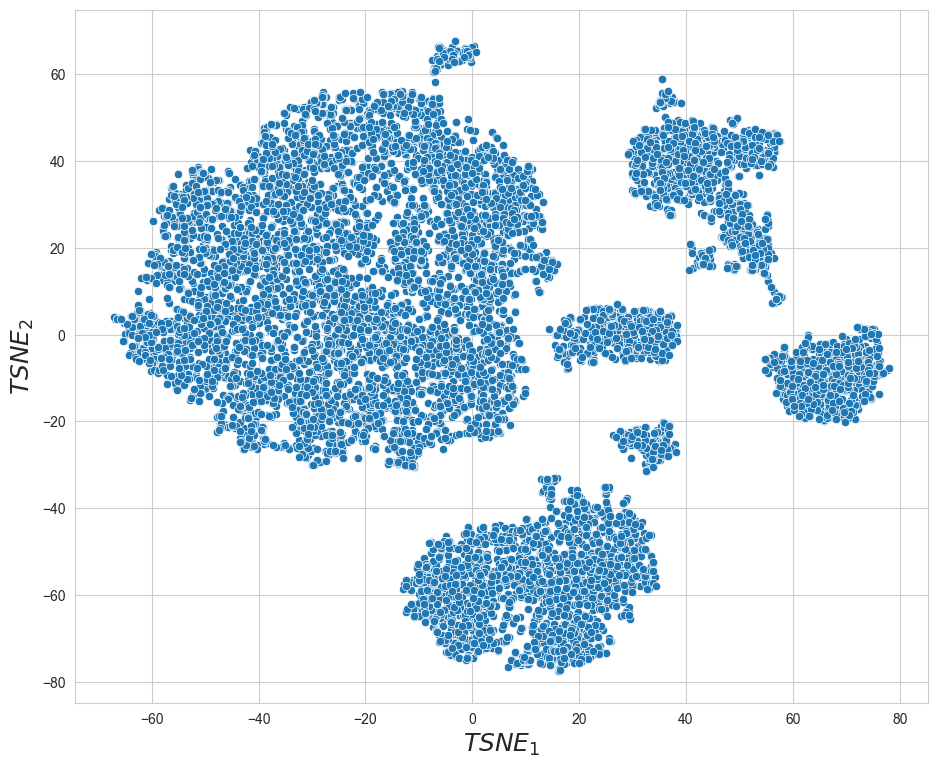

In [28]:
tsne_res = plot_tsne(fc_data_no_outliers_norm)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [30]:
#Сделаем кластеризацию с помощью Mykmeans
#Создадим модель с параметром n_clusters = 4
kmeans = KMeans(n_clusters=4)
#Обучим модель
kmeans.fit(fc_data_no_outliers_norm)
#Предскажем кластеры
kmeans_pred = kmeans.predict(fc_data_no_outliers_norm)

Силуэт: 0.5102552654298014


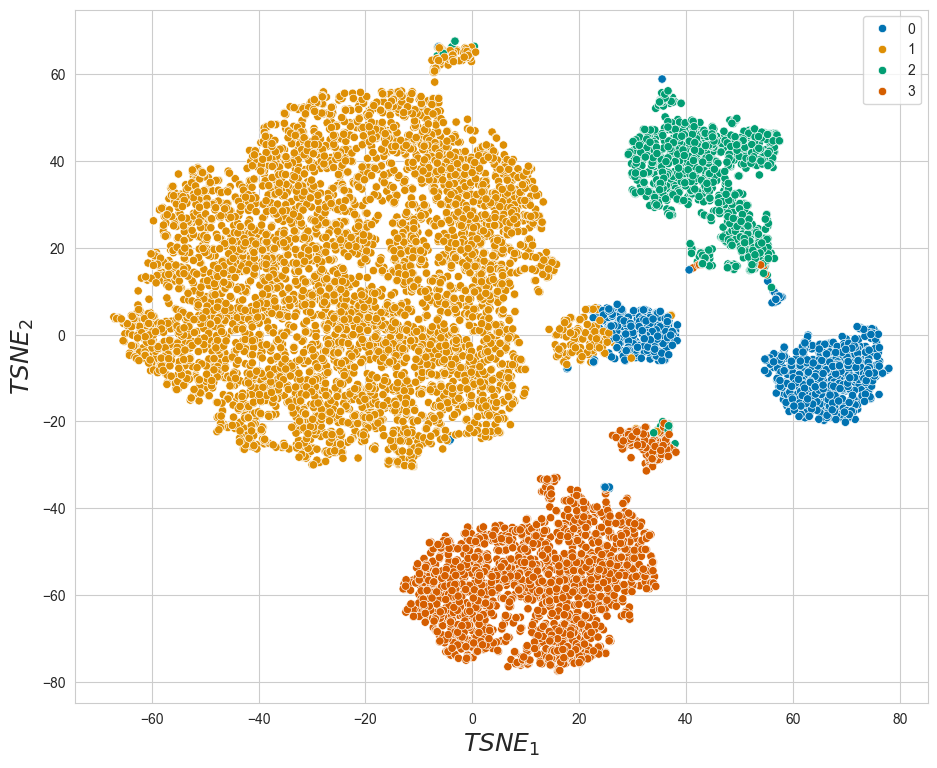

In [31]:
tsne_kmeans_4 = plot_tsne(fc_data_no_outliers_norm, color = kmeans_pred)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, kmeans_pred)}")

In [32]:
#Сделаем кластеризацию с помощью kmeans
#Создадим модель с параметром n_clusters = 5
kmeans = KMeans(n_clusters=5)
#Обучим модель
kmeans.fit(fc_data_no_outliers_norm)
#Предскажем кластеры
kmeans_pred = kmeans.predict(fc_data_no_outliers_norm)

Силуэт: 0.519333794404854


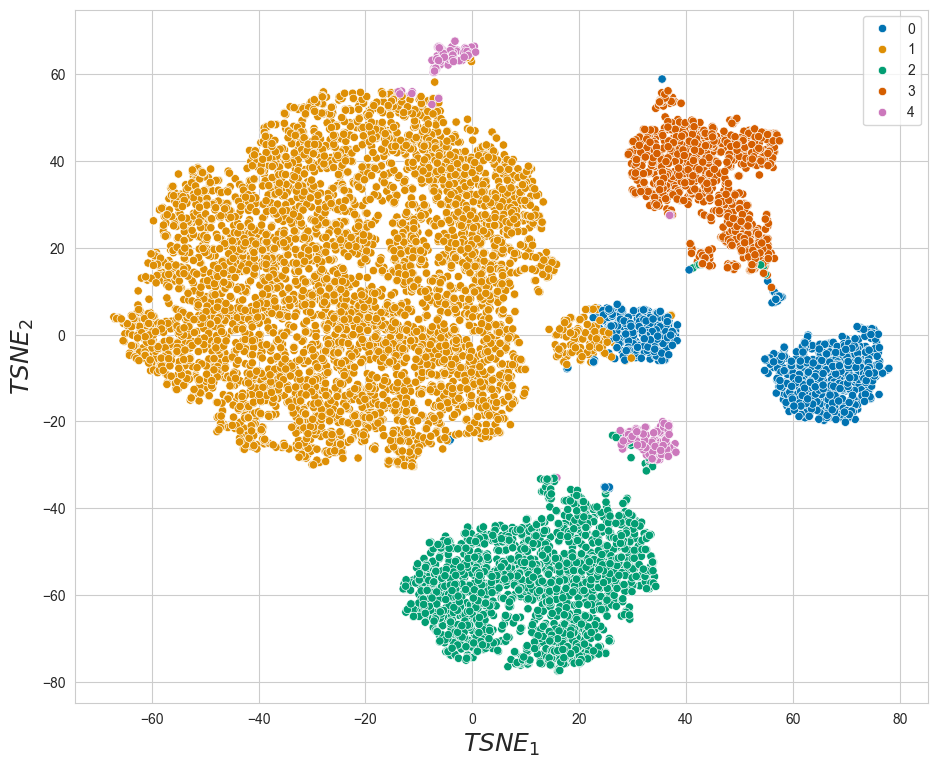

In [33]:
tsne_kmeans_5 = plot_tsne(fc_data_no_outliers_norm, color = kmeans_pred)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, kmeans_pred)}")

Выглядит как-то не очень хорошо:( Попробуем другой алгоритм

In [34]:
#Используем функцию которую мы написали ранее для выбора параметром для алгоритма иерархической кластеризации
algorithm_selection(X = fc_data_no_outliers_norm, n_clusters = 4).sort_values('Silhouette', ascending = False)
#Возьмем следующие сочетания параметров: euclidean (average), manhattan (single), cosine (average). Также дополнительно проверим как сработает euclidean (ward)

Distance Algorithm  Silhouette
4   manhattan    single    0.620792
6      cosine   average    0.618147
0   euclidean   average    0.585570
9   minkowski   average    0.585570
1   euclidean    single    0.575817
10  minkowski    single    0.575817
3   manhattan   average    0.515227
5   manhattan  complete    0.498859
2   euclidean  complete    0.431971
11  minkowski  complete    0.431971
8      cosine  complete    0.281883
7      cosine    single   -0.300078

Силуэт: 0.5855701731713142


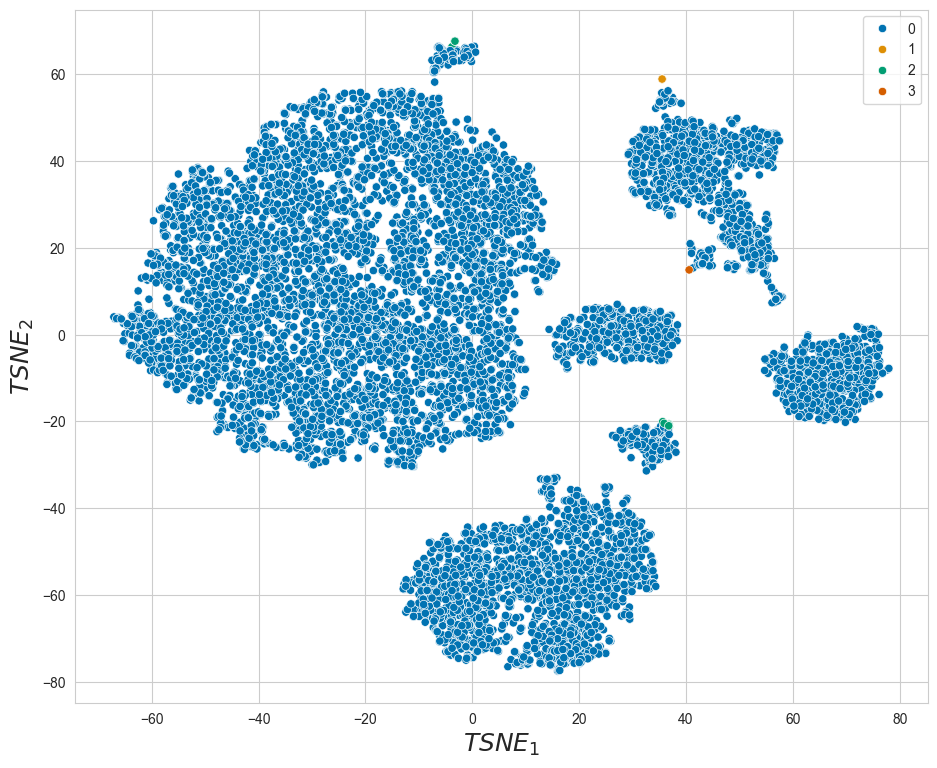

In [35]:
#Сделаем кластеризацию с помощью average (euclidean)
model_average_eucl = AgglomerativeClustering(n_clusters=4, metric = 'euclidean', linkage = 'average')
pred_model_average_eucl = model_average_eucl.fit_predict(fc_data_no_outliers_norm)
#нарисуем tSNE и посчитаем метрику
tsne_average_eucl = plot_tsne(fc_data_no_outliers_norm, color = pred_model_average_eucl)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, pred_model_average_eucl)}")
#Очень грустный результат вышел (кластеры не разделились)

Силуэт: 0.48444469053321304


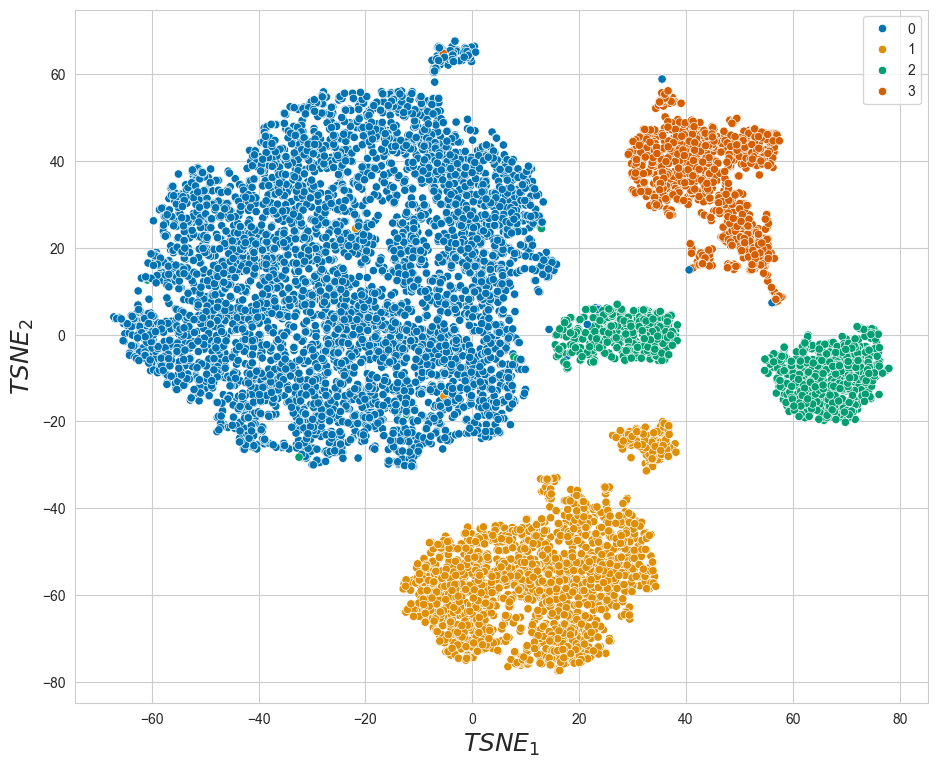

In [36]:
#Сделаем кластеризацию с помощью average (cosine)
model_average_cosine = AgglomerativeClustering(n_clusters=4, metric = 'cosine', linkage = 'average')
pred_model_average_cosine = model_average_cosine.fit_predict(fc_data_no_outliers_norm)
#нарисуем tSNE и посчитаем метрику
tsne_average_cosine = plot_tsne(fc_data_no_outliers_norm, color = pred_model_average_cosine)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, pred_model_average_cosine)}")
#Кажется получился неплохой результат, группы хорошо поделились. Визуально выглядит хорошо, но силуэт ниже.

Силуэт: 0.5838293164714675


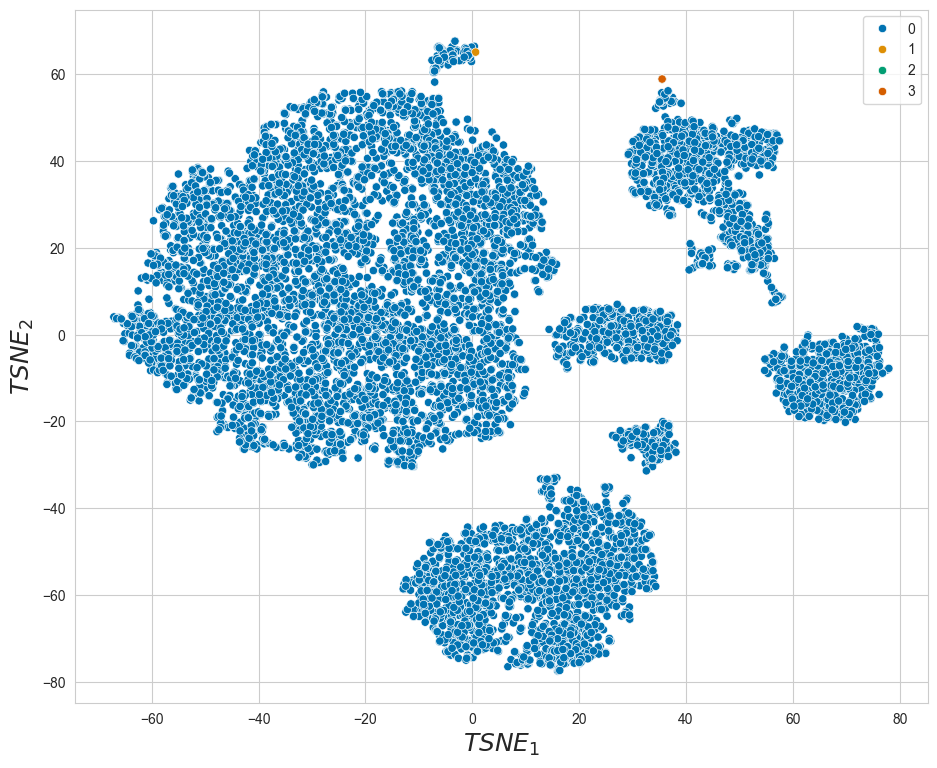

In [37]:
#Сделаем кластеризацию с помощью single (manhattan)
model_single_manh = AgglomerativeClustering(n_clusters=4, metric = 'manhattan', linkage = 'single')
pred_model_single_manh = model_single_manh.fit_predict(fc_data_no_outliers_norm)
#нарисуем tSNE и посчитаем метрику
tsne_single_manh = plot_tsne(fc_data_no_outliers_norm, color = pred_model_single_manh)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, pred_model_single_manh)}")
#Выглядит грустно! Предыдущий был лучше.

Силуэт: 0.48078227313462835


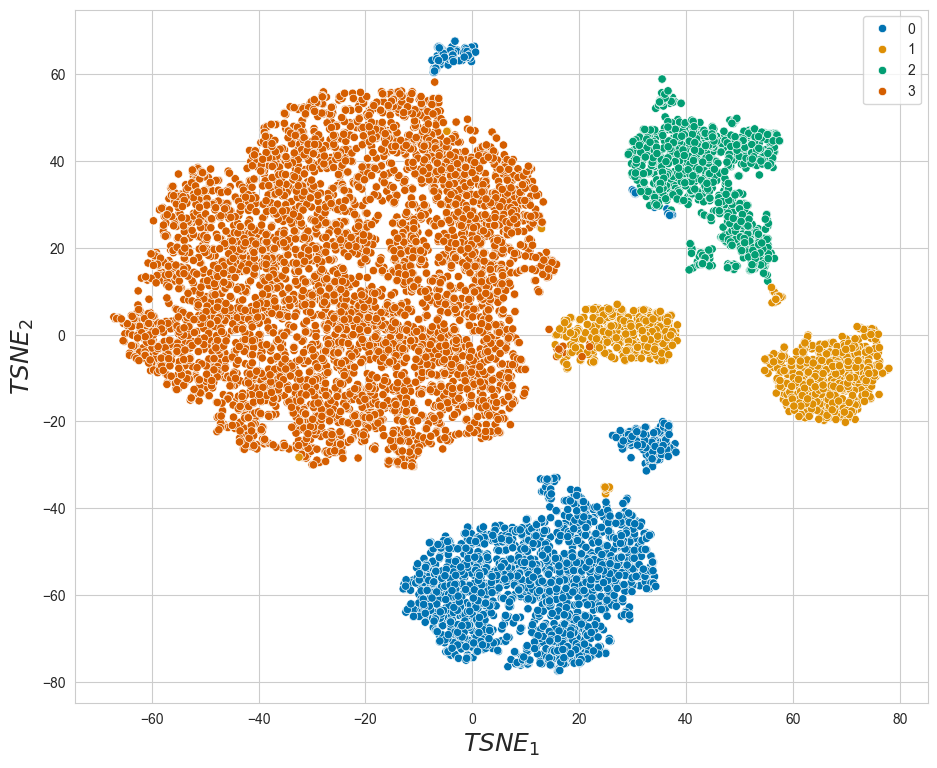

In [38]:
#Сделаем кластеризацию с помощью ward (euclidean)
model_ward_eucl = AgglomerativeClustering(n_clusters=4, metric = 'euclidean', linkage = 'ward')
pred_model_ward_eucl = model_ward_eucl.fit_predict(fc_data_no_outliers_norm)
#нарисуем tSNE и посчитаем метрику
tsne_ward_eucl = plot_tsne(fc_data_no_outliers_norm, color = pred_model_ward_eucl)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, pred_model_ward_eucl)}")
#Выглядит неплохо, похоже на то, что получалось с использованием алгоритма average и метрики расстояния: cosine

Иерархическая кластеризация позволила более точно разметить кластеры чем kmeans. Лучше всего получилось с использованием ward (euclidean) и average (cosine)

In [39]:
#Также попробуем кластеризовать данные с использованием DBSCAN
metrics = ['euclidean', 'manhattan']
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
eps = [0.5, 0.7, 1, 3, 4, 5]
min_samples = [5, 10, 15]

column_names = ['metric','algorithm','eps','min_samples','silhouette_metric']
compare_dataframe = pd.DataFrame(columns = column_names)
        
for metric in metrics:
    for algorithm in algorithms:
        for ep in eps:
            for min_sample in min_samples:
                clust_model = DBSCAN(eps=ep, min_samples=min_sample, metric=metric, algorithm=algorithm, n_jobs=-1)
                pred_clusters = clust_model.fit_predict(fc_data_no_outliers_norm)
                try:
                    silhouette_metric = silhouette_score(fc_data_no_outliers_norm, pred_clusters, metric = metric)
                except ValueError:
                    pass
                compare_dataframe.loc[len(compare_dataframe)] = [metric, algorithm, ep, min_sample, silhouette_metric]


In [40]:
compare_dataframe.sort_values(by='silhouette_metric', ascending=False)

metric  algorithm  eps  min_samples  silhouette_metric
70   euclidean      brute  5.0           10           0.838262
16   euclidean       auto  5.0           10           0.838262
69   euclidean      brute  5.0            5           0.838262
52   euclidean    kd_tree  5.0           10           0.838262
51   euclidean    kd_tree  5.0            5           0.838262
..         ...        ...  ...          ...                ...
79   manhattan       auto  1.0           10          -0.401260
132  manhattan      brute  1.0            5          -0.504151
114  manhattan    kd_tree  1.0            5          -0.504151
96   manhattan  ball_tree  1.0            5          -0.504151
78   manhattan       auto  1.0            5          -0.504151

[144 rows x 5 columns]

Похоже, что наиболее сильное влияние оказывает выбор eps

Силуэт: 0.8382616538042055


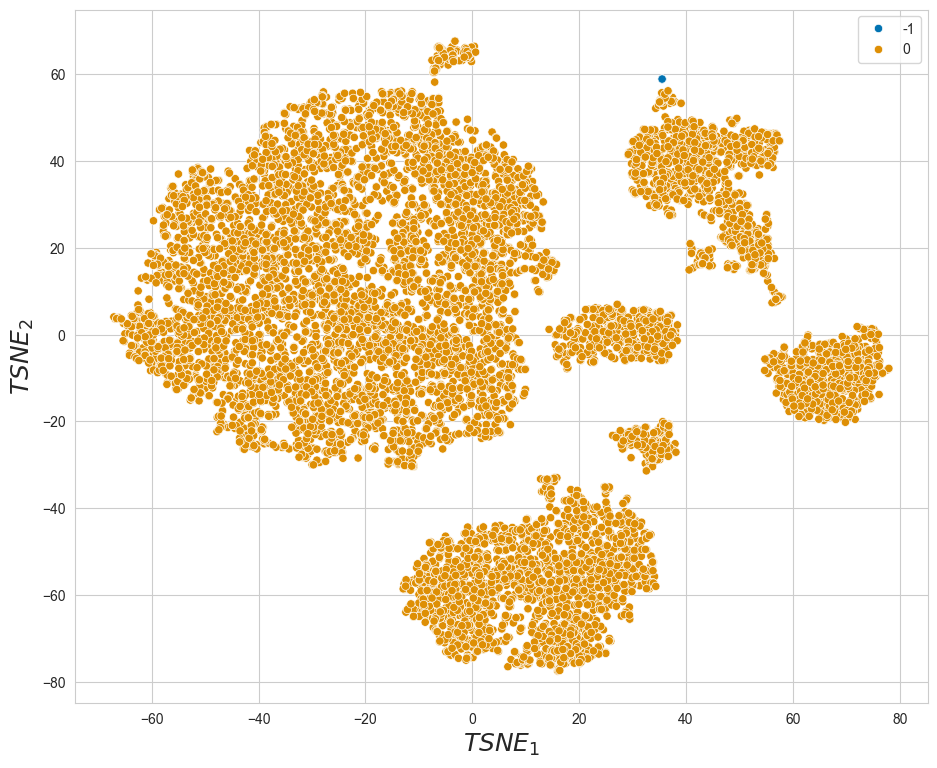

In [41]:
dbscan1 = DBSCAN(eps=5, min_samples=10, metric='euclidean', algorithm='auto',n_jobs=-1)
pred_model_dbscan1 = dbscan1.fit_predict(fc_data_no_outliers_norm)
#нарисуем tSNE и посчитаем метрику
tsne_dbscan1 = plot_tsne(fc_data_no_outliers_norm, color = pred_model_dbscan1)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, pred_model_dbscan1)}")
#Сильно грустно выглядит

Силуэт: 0.6332552623047254


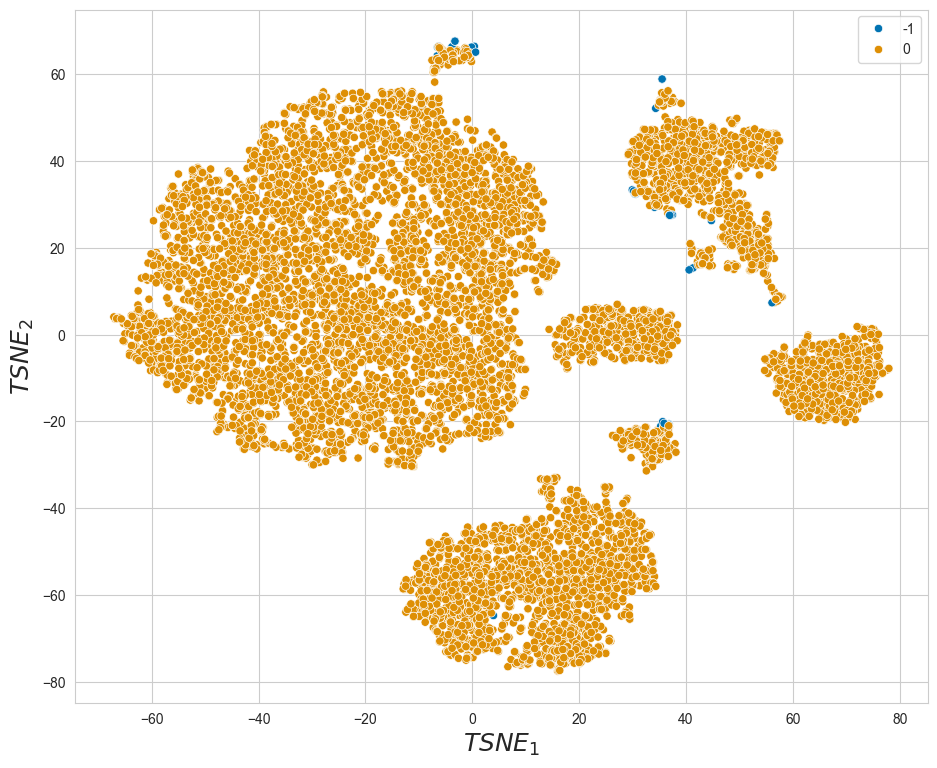

In [42]:
dbscan2 = DBSCAN(eps=5, min_samples=10, metric='manhattan', algorithm='auto', n_jobs=-1)
pred_model_dbscan2 = dbscan2.fit_predict(fc_data_no_outliers_norm)
#нарисуем tSNE и посчитаем метрику
tsne_dbscan2 = plot_tsne(fc_data_no_outliers_norm, color = pred_model_dbscan2)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, pred_model_dbscan2)}")

Силуэт: 0.7719392893104888


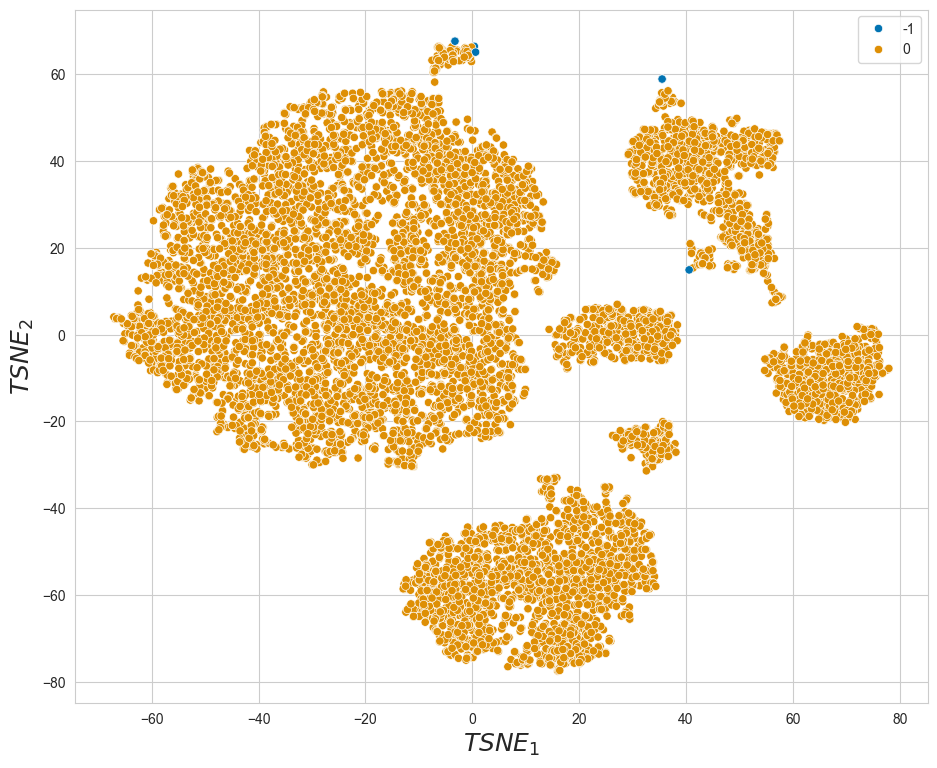

In [43]:
dbscan3 = DBSCAN(eps=4.0, min_samples=10, metric='euclidean', algorithm='auto', n_jobs=-1)
pred_model_dbscan3 = dbscan3.fit_predict(fc_data_no_outliers_norm)
#нарисуем tSNE и посчитаем метрику
tsne_dbscan3 = plot_tsne(fc_data_no_outliers_norm, color = pred_model_dbscan3)
print(f"Силуэт: {silhouette_score(fc_data_no_outliers_norm, pred_model_dbscan3)}")

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет? 
Да, если ставить гиперпараметр - количество кластеров = 4, то 2 соседние группы точек красятся в один цвет.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

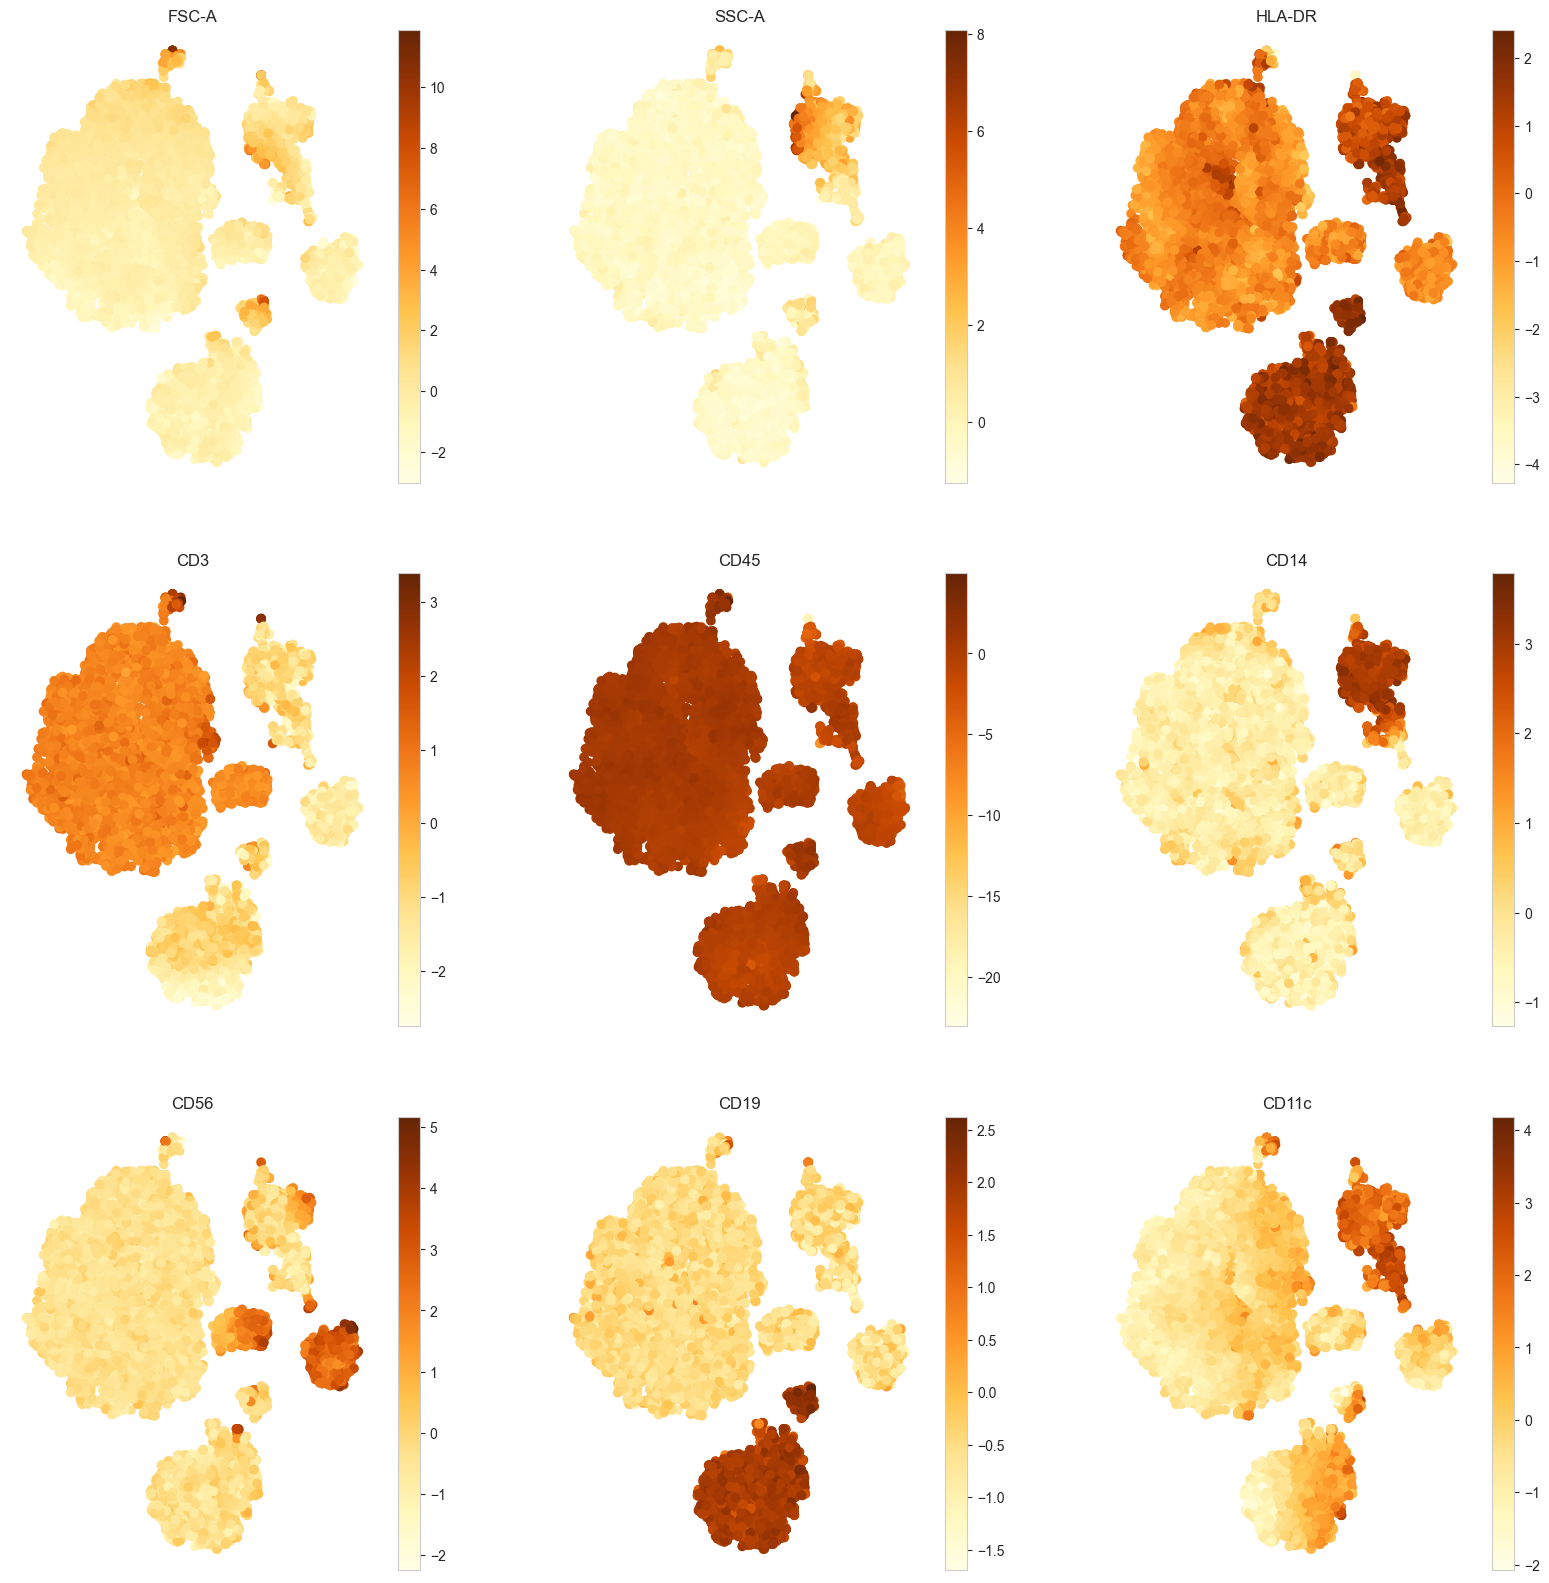

In [44]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_no_outliers_norm.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_no_outliers_norm[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [45]:
cell_type_cluster_map = {0: "B_cells", #CD19 
                         1: "Other_cells",
                         2: "Monocytes", #CD14, CD11c, SSC-A
                         3: "T_cells"} #CD3  

In [46]:
labeled_fc_data = fc_data_no_outliers_norm.assign(Population=model_ward_eucl.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [47]:
labeled_fc_data.Population.value_counts()

Population
T_cells        5676
B_cells        2138
Other_cells    1119
Monocytes      1065
Name: count, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [48]:
path = '../data'
labeled_fc_data.to_csv(join(path, 'labeled_fc_data.csv'))

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [55]:
#Разделим данные на тестовую и тренировочную выборки
X = labeled_fc_data.drop('Population', axis = 1)
y = labeled_fc_data.Population

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30,
                                                    random_state=SEED, stratify=y)

In [56]:
#Обучим модель логистической регрессии и предскажем значения
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(f"F1_score = {f1_score(y_test, y_pred, average='macro')}")
#Высокое значение F1_score может говорить о том, что модель хорошо предсказывает классы

F1_score = 0.9906213836092765


In [57]:
#Построим модель KNN
knn_classifier =  KNeighborsClassifier()
#Подберем оптимальный параметр для модели
knn_params = {"n_neighbors" : np.arange(1,11,1)}
grid = GridSearchCV(knn_classifier, knn_params, cv = 10)
grid.fit(X_train, y_train)
#Создадим модель с оптимальным параметром n_neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=grid.best_params_["n_neighbors"]).fit(X_train, y_train)
#Сделаем предсказания на тестовых данных
predictions = knn_classifier.predict(X_test)
print(f"F1_score = {f1_score(y_test, predictions, average='macro')}")

F1_score = 0.9956708123766085


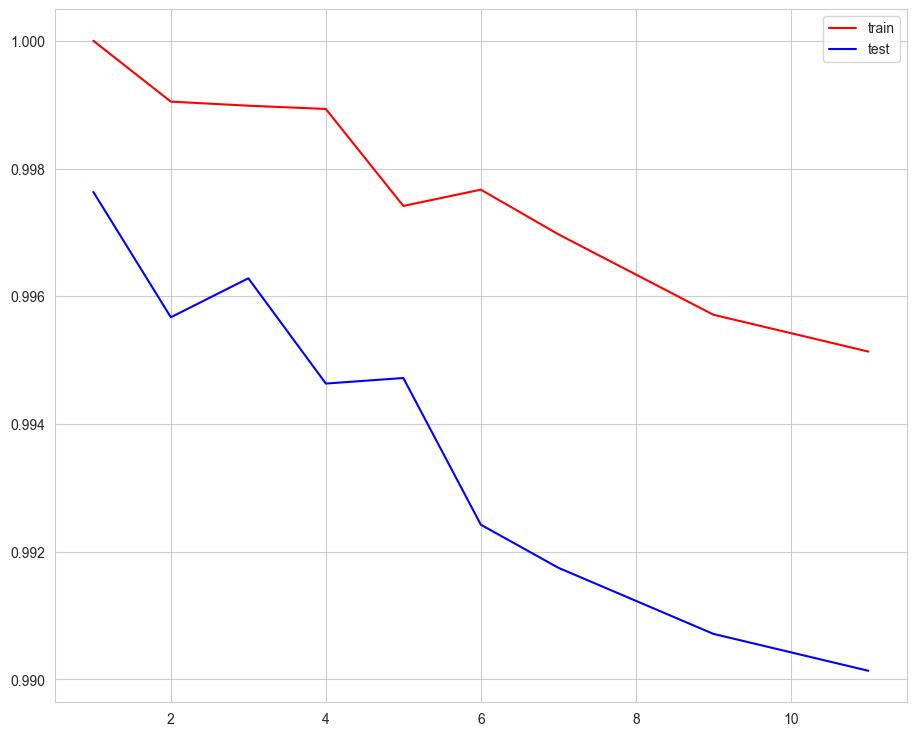

In [52]:
#Посмотрим на изменение метрики при изменении параметра "n_neighbors"
params = [1,2,3,4,5,6,7,9,11]
train_metric = []
test_metric = []
    
for k in params:
    knn_clas= KNeighborsClassifier(k)
    knn_clas.fit(X_train, y_train)
    pred_test = knn_clas.predict(X_test)
    pred_train = knn_clas.predict(X_train)
    train_metric.append(f1_score(y_train, pred_train, average='macro'))
    test_metric.append(f1_score(y_test, pred_test, average='macro'))

sns.lineplot(x = params, y = train_metric, label = 'train', color = 'red')
sns.lineplot(x = params, y = test_metric, label = 'test', color = 'blue');
#Можно взять 3

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Мне очень нравится Италия. Я там не была, но очень хотела бы побывать. Еще хочу съездить в Ереван. Я была там в детстве, но это было слишком давно:)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**